# Gene Expression variance analysis - curated gene lists

Cohorts
- ClinGen Haplo-insufficient (HI)
- Used tracks 7531 - 7533 (RNA:blood); 7563 - 7565 (RNA:liver); 7539 - 7541 (RNA:brain); 7569 - 7571 (RNA:muscle); 7551 - 7553 (RNA:esophagus)
- Non-essential (PMID 25645873) - 6112 - 6121 (RNA:GM12878)

## Per-gene summary statistics

For every gene \(g\) we first **filter** its variant table to **biallelic SNPs** with
minor-allele frequency (AF) \(\ge 0.01\).
Let the remaining set of variants be
\(\mathcal V_g = \{v_1,\ldots ,v_{N_g}\}\) with

* predicted expression difference
 $(\displaystyle )\Delta_i = \texttt{DELTA}(v_i))$
* allele frequency
  $(f_i = \texttt{AF}(v_i))$.

---

| quantity | formula                                                                                                                                        | code column |
|----------|------------------------------------------------------------------------------------------------------------------------------------------------|-------------|
| **number of SNPs** | $( \text{num\_snps}_g = N_g)$                                                                                                                  | `num_snps` |
| **per-variant cis-variance** | $(\text{VAR\_I}_i = \Delta_i^{\,2}\; 2f_i(1-f_i))$                                                                                             | produced earlier by *variant scoring* script |
| **predicted cis-variance (gene-level)** | $(\operatorname{Var}^{\text{cis}}_g = \sum_{i\in\mathcal V_g}\text{VAR\_I}_i)$                                                                 | `predicted_cis_variance` |
| **mean / median AF** | $(\overline f_g = \frac1{N_g}\sum_i f_i,\qquad \tilde f_g = \operatorname{median}(f_i))$                                                       | `mean_AF`, `median_AF` |
| **mean / median Δ** | $(\overline\Delta_g = \frac1{N_g}\sum_i \Delta_i,\qquad \tilde\Delta_g = \operatorname{median}(\Delta_i))$                                     | `mean_DELTA`, `median_DELTA` |
| **mean / median VAR\_I** | $(\overline{\text{VAR\_I}}_g = \frac1{N_g}\sum_i \text{VAR\_I}_i,\qquad \widetilde{\text{VAR\_I}}_g = \operatorname{median}(\text{VAR\_I}_i))$ | `mean_VAR_I`, `median_VAR_I` |

---

### Notes

* The $(2f(1-f))$ term converts the squared effect $(\Delta^{2})$ to **additive genetic variance** under Hardy–Weinberg equilibrium.

## 1. Load and summarize cis-variance predictions from FlashZoi

In [15]:
# Setup
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pingouin import wilcoxon
from scipy.stats import pearsonr, spearmanr
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from sklearn.linear_model import LinearRegression
import pingouin as pg
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

clingen_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/ClinGen_gene_curation_list"
nonessential_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/nonessential_ensg"

clingen_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv"
nonessential_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv"

gtex_expr_file = "..//data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"

# gtex_sample_expr_file = "../../data/initial/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"
# sample_annot_file = "../../data/initial/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"

gene_metrics_vgh = "/Users/markus/seq2expr-variance/data/initial/gene_metrics_vgh_202407.tsv.gz"

In [17]:
def load_variants_summary(
        variants_scored_dir: str,
        cache_file: str,
        min_af: float = 0.01,
        force_reload: bool = False
    ) -> pd.DataFrame:
    """
    Build a per-gene summary table from scored-variant folders.
    variants_scored_dir : str
        Path containing one sub-folder per gene, each with <gene>_variants.tsv.
    cache_file : str
        Where the summary TSV will be cached / read from.
    min_af : float, optional
        Minimum alternate-allele frequency (inclusive) to keep a variant. Filtering the common variants here
    force_reload : bool, optional
        Ignore an existing cache and rebuild the summary
    """
    if os.path.exists(cache_file) and not force_reload:
        var_df = pd.read_csv(cache_file, sep="\t")
        print(f"Loaded cached gene summary table: {cache_file}")
        return var_df

    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id  = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue

        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        # ── AF filtering ───────────────────────────────────────────
        if "AF" not in df.columns:
            continue  # skip malformed tables
        df["AF"] = pd.to_numeric(df["AF"], errors="coerce")
        before = len(df)
        df = df[df["AF"] >= min_af].reset_index(drop=True)
        after = len(df)
        # Uncomment for debugging:
        # print(f"{gene_id}: kept {after}/{before} variants with AF ≥ {min_af}")

        if df.empty or not {"VAR_I", "DELTA"}.issubset(df.columns):
            continue

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median()
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")
    return var_df

var_df_clingen = load_variants_summary(clingen_scored_dir, clingen_cache,
                                       min_af=0.01, force_reload=True)
var_df_nonessential = load_variants_summary(nonessential_scored_dir, nonessential_cache,
                                            min_af=0.01, force_reload=True)

print("ClinGen:", var_df_clingen.shape)
print(var_df_clingen.head())
print("Non-essential:", var_df_nonessential.shape)
print(var_df_nonessential.head())

Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv
Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv
ClinGen: (314, 9)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000015171            5.192293e-07      1993  0.224439   0.083773   
1  ENSG00000089225            8.054877e-07      2875  0.176341   0.078200   
2  ENSG00000182774            3.950705e-04      2685  0.164024   0.065789   
3  ENSG00000096696            1.180269e-04      2848  0.216798   0.123680   
4  ENSG00000179348            5.482736e-07      2364  0.198366   0.053371   

     mean_DELTA  median_DELTA    mean_VAR_I  median_VAR_I  
0 -7.799352e-07  0.000000e+00  2.605265e-10  9.501787e-13  
1 -3.529641e-06 -7.059425e-07  2.801696e-10  1.369285e-12  
2  9.653000e-05  4.816055e-05  1.471399e-07  9.763669e-10  
3 -3.176069e-05 -3.325939

Non-essential set contains the current outlier (3× larger)
- ClinGen genes look “tightly guarded” – they have smaller predicted variability in how much their expression can change when common DNA variants are present.
- Non-essential genes carry more and stronger common variants, so their expression is predicted to wobble more.



## 2. Distribution overview of gene-level predicted variance

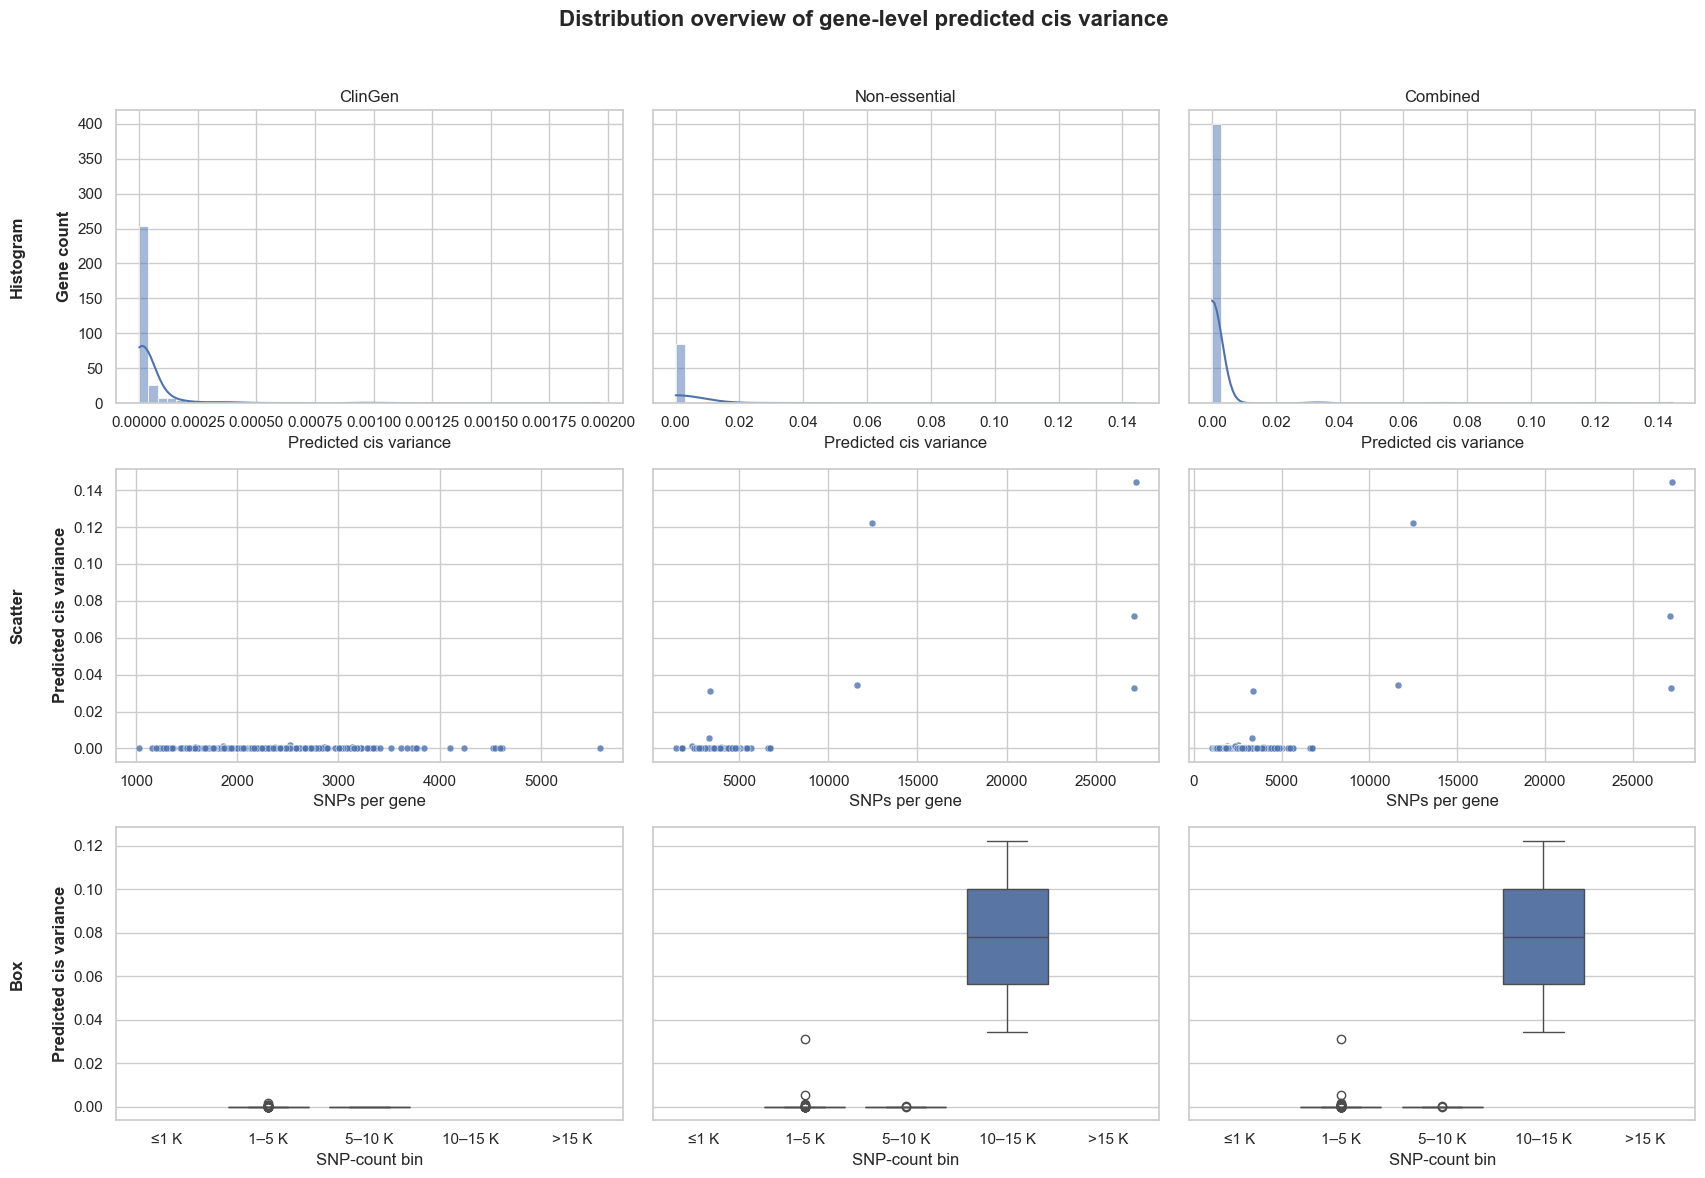

In [18]:
sns.set_theme(style="whitegrid")

var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Non-essential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)
var_df_all["cohort"] = "Combined"

cohort_dfs = {
    "ClinGen"        : var_df_clingen,
    "Non-essential"  : var_df_nonessential,
    "Combined"       : var_df_all
}

fig, axes = plt.subplots(3, 3, figsize=(17, 12), sharey="row")
plot_types = ["Histogram", "Scatter", "Box"]

for col, (cohort_name, df) in enumerate(cohort_dfs.items()):
    # 1) histogram of cis variance
    sns.histplot(df["predicted_cis_variance"],
                 bins=50, kde=True, ax=axes[0, col])
    axes[0, col].set_title(f"{cohort_name}")
    axes[0, col].set_xlabel("Predicted cis variance")
    axes[0, col].set_ylabel("Gene count" if col == 0 else "")

    # 2) scatter SNP count vs cis variance
    sns.scatterplot(data=df, x="num_snps", y="predicted_cis_variance",
                    ax=axes[1, col], s=25, alpha=0.8)
    axes[1, col].set_xlabel("SNPs per gene")
    axes[1, col].set_ylabel("Predicted cis variance" if col == 0 else "")

    # 3) cis variance binned by SNP count
    tmp = df.copy()
    tmp["snp_bin"] = pd.cut(tmp["num_snps"],
                            bins=[0, 1000, 5000, 10000, 15000, 20000],
                            labels=["≤1 K", "1–5 K", "5–10 K", "10–15 K", ">15 K"])
    sns.boxplot(data=tmp, x="snp_bin", y="predicted_cis_variance",
                ax=axes[2, col])
    axes[2, col].set_xlabel("SNP-count bin")
    axes[2, col].set_ylabel("Predicted cis variance" if col == 0 else "")

for row, label in enumerate(plot_types):
    axes[row, 0].set_ylabel(axes[row, 0].get_ylabel(), weight="bold")
    axes[row, 0].annotate(label, xy=(-0.18, 0.5),
                          xycoords="axes fraction", va="center",
                          ha="right", fontsize=12, weight="bold",
                          rotation=90)

fig.suptitle("Distribution overview of gene-level predicted cis variance",
             fontsize=16, weight="bold")
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- ClinGen genes cluster tightly at very low predicted variance; no serious tail.
- Non-essential genes look similar until you hit a few giants that inflate the mean and the y-axis
- Hence, any simple “average” comparison will be distorted by those few high-variance, high-SNP genes
- it seems like the more SNPs means more summed variance, adding more terms in Σ 2p(1-p)Δ² naturally pushes the total up

## 3. Distribution analysis

### 3.1 Basic stats

In [32]:
metric   = "predicted_cis_variance"
hi_vals  = var_df_clingen[metric]
ne_vals  = var_df_nonessential[metric]

u, p_u   = mannwhitneyu(hi_vals, ne_vals, alternative="two-sided")
d        = pg.compute_effsize(hi_vals, ne_vals, eftype="cohen")
auc      = pg.compute_effsize(hi_vals, ne_vals, eftype="AUC")

cliff    = 2 * auc - 1   # convert AUC → Cliff’s δ

print(f"Mann–Whitney U p = {p_u:.2e}")
print(f"Cohen's d        = {d:+.2f}") # The shift is only 0.18 SD—barely past “small” threshold (0.20)
print(f"Cliff's delta    = {cliff:+.2f}") # If we pick one random HI gene and one random non-essential gene, the HI gene’s cis-variance is higher ca 55 % of the time

# import inspect, pingouin as pg
# print(inspect.getsource(pg.compute_effsize))

Mann–Whitney U p = 2.79e-08
Cohen's d        = -0.47
Cliff's delta    = -0.26


1. The two distributions differ very reliably.
2. Medium-sized shift: ClinGen genes have on average ~½ SD lower predicted variance than non-essential genes.
3. Picking one ClinGen and one non-essential gene at random: there’s a 63 % chance the non-essential gene shows the higher variance (δ = –0.26 = 0.5 – 0.24).
- Common-variant cis-variance is significantly and moderately lower in ClinGen genes than in non-essential genes

### 3.2 Log-fold change vs background

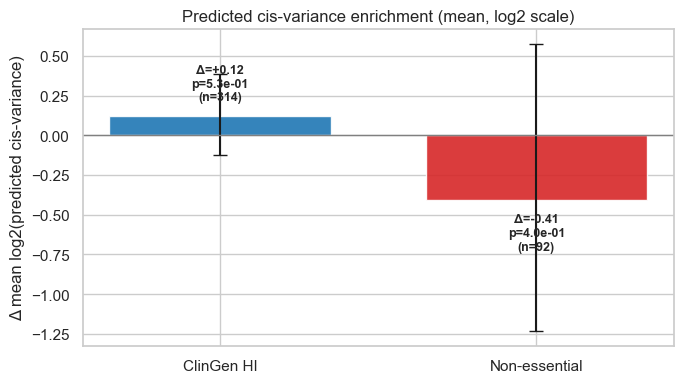

In [46]:
def bar_against_bg_mean(df_subset, label, ax, color,
                        bg_df=var_df_all, n_boot=5000):
    """
    Draw one bar showing Δ-mean log₂(predicted cis-variance) for *df_subset*
    relative to *bg_df*.  Error bar = bootstrap 95 % CI of that shift.
    """
    bg_log     = np.log2(bg_df["predicted_cis_variance"] + 1e-6)
    subset_log = np.log2(df_subset["predicted_cis_variance"] + 1e-6)

    mean_shift = subset_log.mean() - bg_log.mean()

    ci_low, ci_high = pg.compute_bootci(subset_log, func=np.mean,
                                        n_boot=n_boot, confidence=0.95)
    ci_low_shift, ci_high_shift = ci_low - bg_log.mean(), ci_high - bg_log.mean()

    ax.bar(label, mean_shift, color=color, width=0.7,
           yerr=[[mean_shift - ci_low_shift],
                 [ci_high_shift - mean_shift]],
           capsize=5, alpha=0.9)

    # Welch t-test on the same log₂ values
    p_val = ttest_ind(subset_log, bg_log, equal_var=False).pvalue

    ax.text(label, mean_shift + 0.08*np.sign(mean_shift or 1),
            f"Δ={mean_shift:+.2f}\n"
            f"p={p_val:.1e}\n"
            f"(n={len(subset_log)})",
            ha="center", va="bottom" if mean_shift>0 else "top",
            fontsize=9, weight="bold")

fig, ax = plt.subplots(figsize=(7, 4))

bar_against_bg_mean(var_df_clingen,      "ClinGen HI",   ax, "#1f77b4")
bar_against_bg_mean(var_df_nonessential, "Non-essential", ax, "#d62728")
#ax.bar("Background", 0, color="lightgray", width=0.7, alpha=0.6)

ax.axhline(0, color="gray", lw=1)
ax.set_ylabel("Δ mean log2(predicted cis-variance)")
ax.set_title("Predicted cis-variance enrichment (mean, log2 scale)")
plt.tight_layout()
plt.show()

ClinGen HI genes

- Average log₂-variance is only 0.12 units (~9 %) higher than the background set
- Confidence interval for the shift straddles zero; p ≈ 0.54 meaning that it is  not significant

Non-essential genes

- Mean is 0.41 log₂ units (~25 %) lower than background
- Again, CI covers zero; p ≈ 0.40 meaning that is not significant.

### 3.3 Adjust for a confounder with ANCOVA


Replacing the pair-wise test with a single model so we can adjust for things like gene length or GC %. The cohort[T.HI] coefficient tells us whether HI genes still carry higher cis-variance after accounting for SNP burden.


In [36]:
var_df_all["cohort"] = np.where(var_df_all["cohort"]=="ClinGen", "HI", "NonEss")

model = smf.ols("np.log10(predicted_cis_variance+1e-6) ~ cohort + num_snps", data=var_df_all).fit()
print(model.summary())

                                       OLS Regression Results                                      
Dep. Variable:     np.log10(predicted_cis_variance + 1e-6)   R-squared:                       0.202
Model:                                                 OLS   Adj. R-squared:                  0.198
Method:                                      Least Squares   F-statistic:                     50.95
Date:                                     Tue, 01 Jul 2025   Prob (F-statistic):           1.88e-20
Time:                                             00:26:49   Log-Likelihood:                -477.53
No. Observations:                                      406   AIC:                             961.1
Df Residuals:                                          403   BIC:                             973.1
Df Model:                                                2                                         
Covariance Type:                                 nonrobust                                         


- R² ≈ 0.20 – SNP count + gene set explains ~20 % of the spread. Plenty of variance still unexplained
- Residual skew (JB ≈ 179, p ≪ 0.001) – errors goes away from normality; consider robust SEs or a rank-based model.
- Condition number 1 × 10⁴ – high only because num_snps ranges over four orders of magnitude; multicollinearity is not a concern with just these two predictors

--------

- Even after we adjust for how many common SNPs a gene carries
- ClinGen haplo-insufficient genes show ~4-fold higher predicted cis-variance than non-essential genes (and the gap is highly significant)
- SNP burden matters, but it does not explain away the dosage-constraint signal

### 3.5 Rank-enrichment across the genome

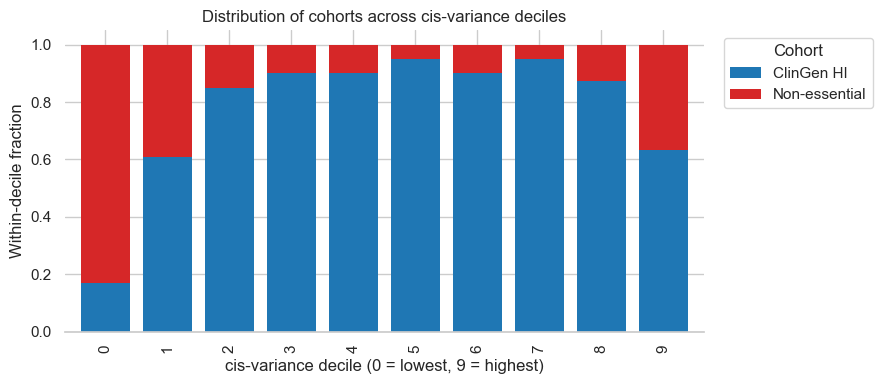

In [49]:
var_df_all_dec = pd.concat([
    var_df_clingen     .assign(cohort="ClinGen HI"),
    var_df_nonessential.assign(cohort="Non-essential")
], ignore_index=True)

# put every gene into a cis-variance decile (0 = lowest 10 %, 9 = top 10 %)
var_df_all_dec["decile"] = pd.qcut(
    var_df_all_dec["predicted_cis_variance"],
    10, labels=False, duplicates="drop"
)

# then we count genes per (decile, cohort) → convert to within-decile fractions
dec_counts = (var_df_all_dec
              .groupby(["decile", "cohort"])
              .size()
              .unstack(fill_value=0))
dec_frac   = dec_counts.div(dec_counts.sum(axis=1), axis=0)

# a stacked bar plot
palette = ["#1f77b4", "#d62728"]
ax = dec_frac.plot(kind="bar", stacked=True, width=0.8,
                   figsize=(9, 4), color=palette, edgecolor="none")

ax.set_ylabel("Within-decile fraction")
ax.set_xlabel("cis-variance decile (0 = lowest, 9 = highest)")
ax.set_title("Distribution of cohorts across cis-variance deciles")
ax.legend(title="Cohort", bbox_to_anchor=(1.02, 1), loc="upper left")
sns.despine(left=True)
plt.tight_layout()
plt.show()

- Non-essential genes are strongly over-represented among the very quiet genes.
- ClinGen HI genes dominate the mid-to-upper part of the variance spectrum.
- The very noisiest windows contain a noticeable share of non-essential genes again (driven by the handful of extreme loci we saw before).
- Relative to non-essential genes, ClinGen HI genes are depleted at the very bottom and enriched throughout the broad middle of the cis-variance ranking. The extreme high tail is mixed because only a few non-essential outliers shoot up the variance scale.


### 3.6 log10-transform the variance (filter zeros to avoid −inf)


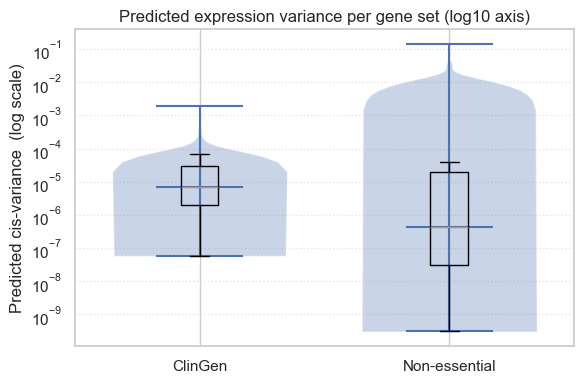

Linear model  log10(var) = -5.779 + 0.135 * log10(SNPs)   (R = 0.02, p = 7.05e-01)


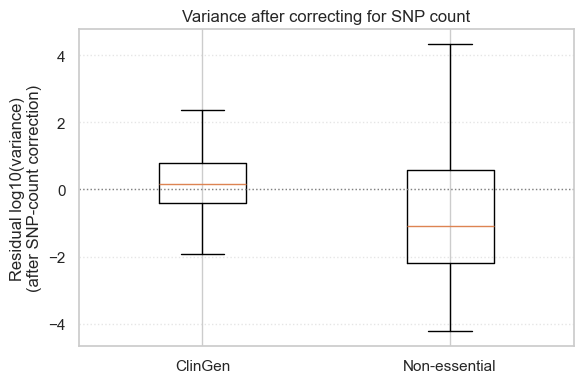

In [51]:
var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()

# ▸ Add the label column that was missing
var_df_clingen["gene_set"]      = "ClinGen"
var_df_nonessential["gene_set"] = "Non-essential"

# ▸ Combine
all_df = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)

# ▸ Keep only rows with positive variance and at least one SNP
all_df = all_df[(all_df["predicted_cis_variance"] > 0) &
                (all_df["num_snps"]                > 0)].copy()

# ---------------------------------------------------------------
# 1. Violin + box plot on a log-y axis
# ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

raw_group_data = [
    all_df.loc[all_df["gene_set"] == "ClinGen",        "predicted_cis_variance"],
    all_df.loc[all_df["gene_set"] == "Non-essential",  "predicted_cis_variance"]
]

vp = ax.violinplot(raw_group_data, showmedians=True, widths=0.7)
ax.boxplot(raw_group_data, widths=0.15, positions=[1, 2], showfliers=False)

ax.set_yscale("log")
ax.set_xticks([1, 2])
ax.set_xticklabels(["ClinGen", "Non-essential"])
ax.set_ylabel("Predicted cis-variance  (log scale)")
ax.set_title("Predicted expression variance per gene set (log10 axis)")
ax.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------
# 2. Regress out SNP-count effect and plot residuals
# ---------------------------------------------------------------
all_df["log10_var"]  = np.log10(all_df["predicted_cis_variance"])
all_df["log10_snps"] = np.log10(all_df["num_snps"])

slope, intercept, r, p, stderr = stats.linregress(
    all_df["log10_snps"], all_df["log10_var"])

print(f"Linear model  log10(var) = {intercept:.3f} + "
      f"{slope:.3f} * log10(SNPs)   (R = {r:.2f}, p = {p:.2e})")

all_df["residual_log10var"] = (
    all_df["log10_var"] - (intercept + slope * all_df["log10_snps"])
)

fig, ax = plt.subplots(figsize=(6, 4))
resid_group_data = [
    all_df.loc[all_df["gene_set"] == "ClinGen",       "residual_log10var"],
    all_df.loc[all_df["gene_set"] == "Non-essential", "residual_log10var"]
]

ax.boxplot(resid_group_data, widths=0.35,
           labels=["ClinGen", "Non-essential"],
           showfliers=False)
ax.axhline(0, color="grey", lw=1, ls=":")
ax.set_ylabel("Residual log10(variance)\n(after SNP-count correction)")
ax.set_title("Variance after correcting for SNP count")
ax.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

- Spread: the Non-essential violin is very wide, stretching from ~10⁻¹⁰ up to 10⁻¹; ClinGen is narrower (10⁻⁹ → 10⁻³). So non-essential genes include a handful of huge outliers but also many very quiet genes, so the distribution is flatter and wider
- Medians: the dark box inside ClinGen sits a little higher than the Non-essential median. So the “typical” ClinGen gene shows slightly larger predicted variance than the typical Non-essential gene, even though Non-essential has the wild high-end tail.
- Upper whisker: Non-essential alone owns the super-high tail (≥10⁻¹). Those few genes are driving any mean-based comparisons; medians are more stable.

 SNP count has negligible predictive power, “correcting” for it barely changes the cohort difference. So ClinGen still tends to show higher variance once we ignore the outliers that inflate the raw non-essential tail.

Variant count is not the driver of the predicted cis-variance differences; ClinGen genes cluster at modest but consistently higher variance, while Non-essential genes are a mixture of very quiet loci and a handful of extreme high-variance outliers.


## 4. Correlation exploring

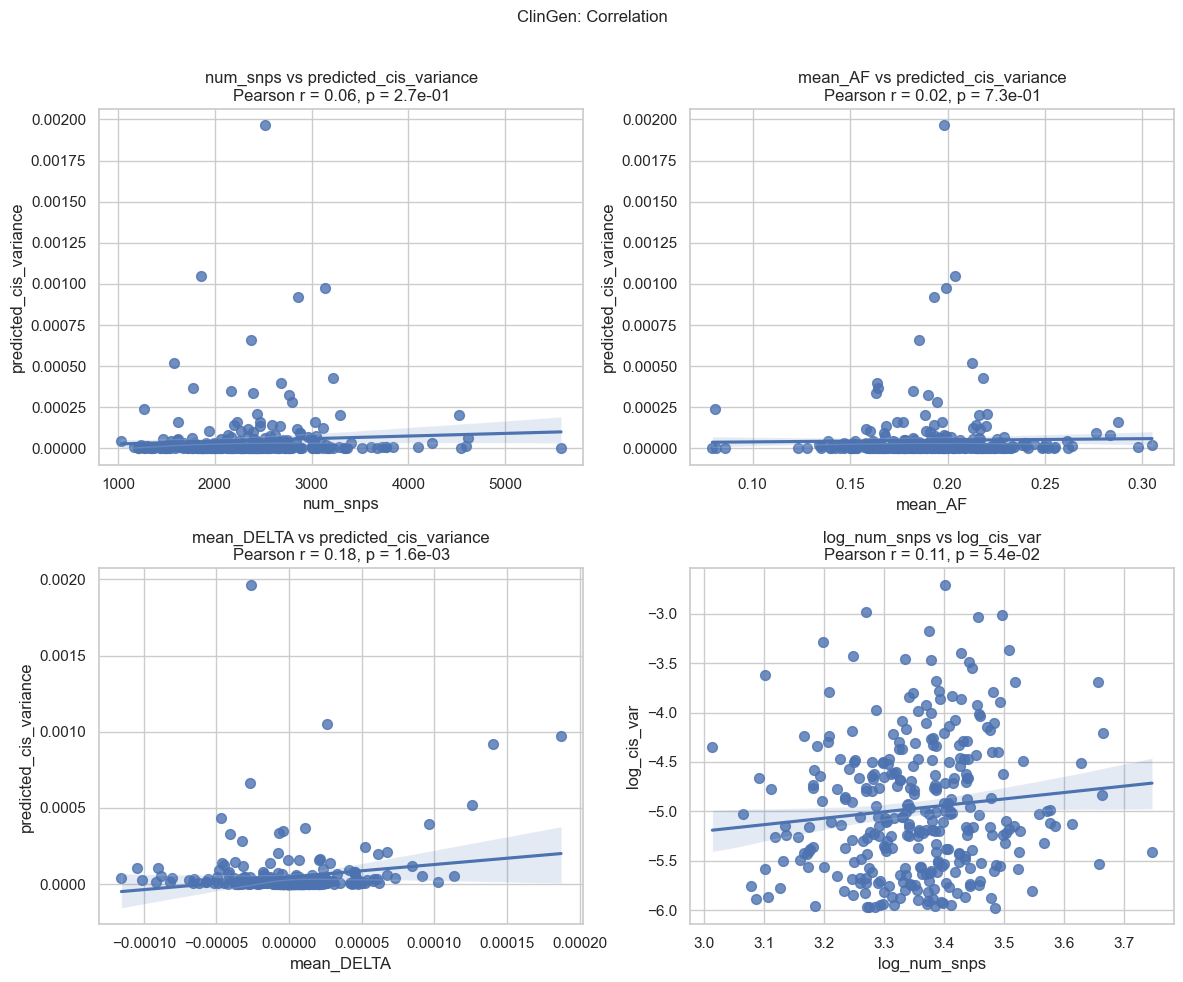

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.063,0.267,0.116,0.040
1,mean_AF,predicted_cis_variance,0.019,0.734,0.048,0.395
2,mean_DELTA,predicted_cis_variance,0.178,0.002,-0.002,0.978
3,log_num_snps,log_cis_var,0.109,0.054,0.116,0.040


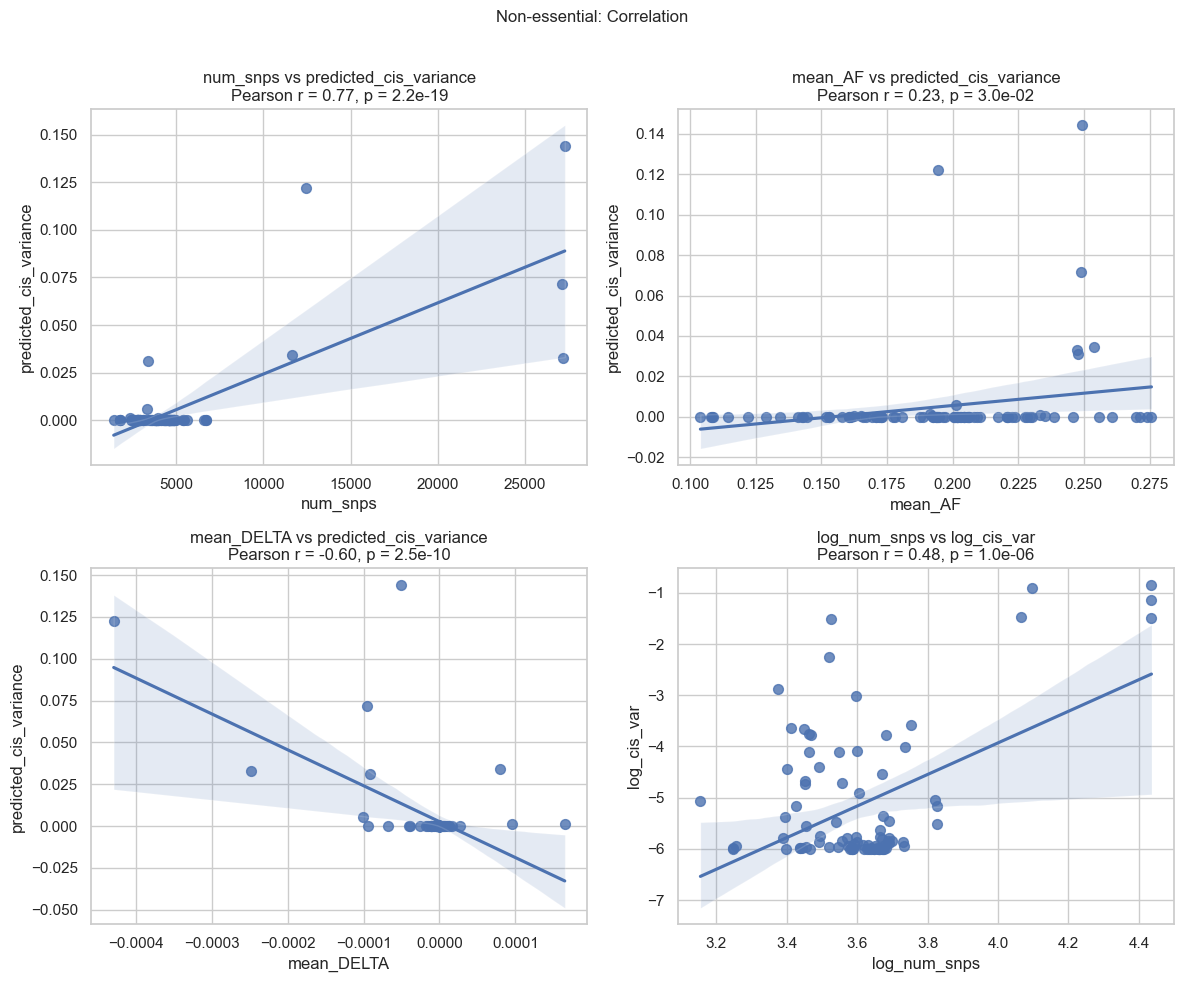

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.772,0.000,0.046,0.665
1,mean_AF,predicted_cis_variance,0.226,0.030,0.324,0.002
2,mean_DELTA,predicted_cis_variance,-0.601,0.000,-0.257,0.013
3,log_num_snps,log_cis_var,0.484,0.000,0.046,0.665


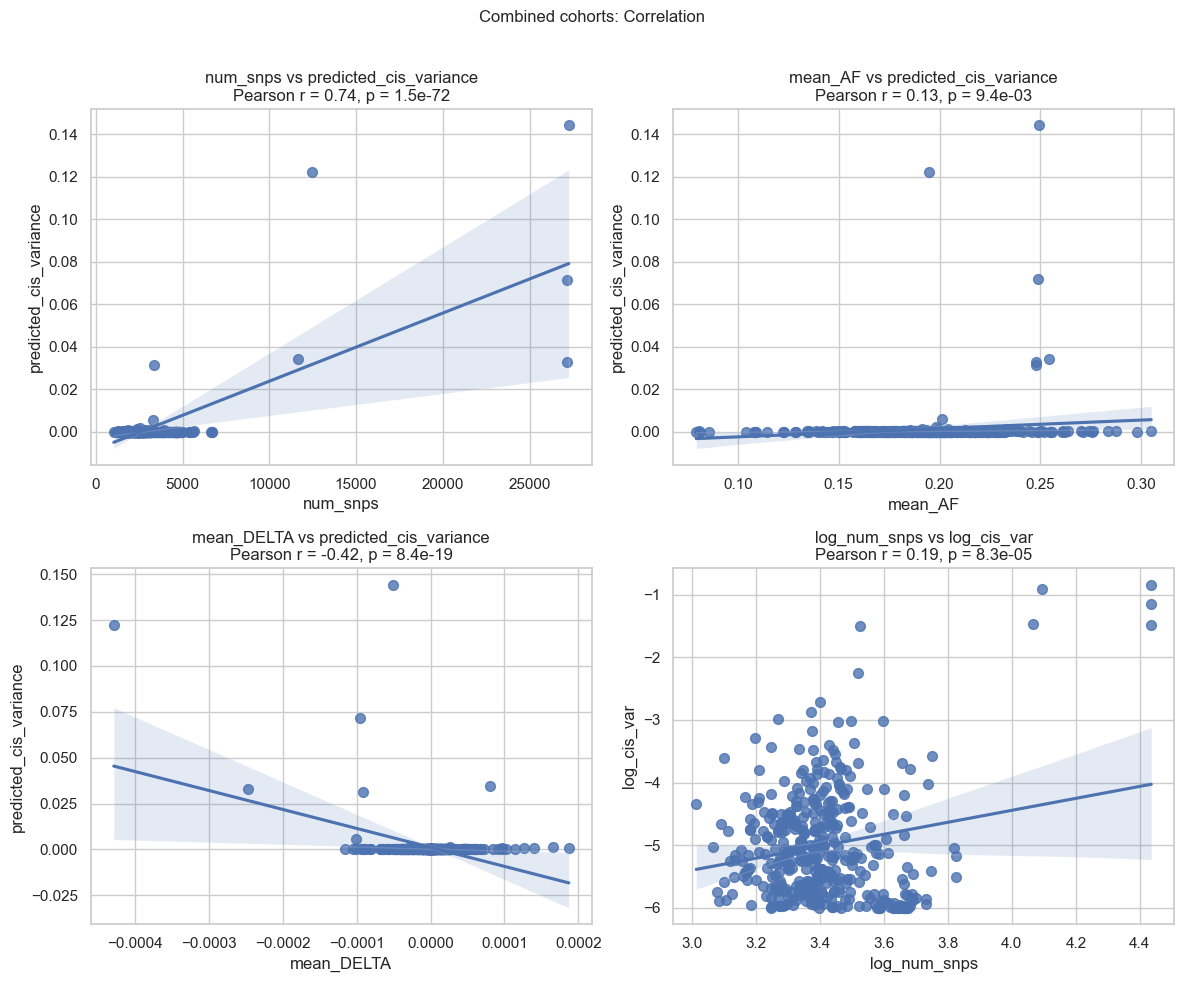

,X,Y,Pearson_r,Pearson_p,Spearman_r,Spearman_p
0,num_snps,predicted_cis_variance,0.743,0.000,-0.095,0.055
1,mean_AF,predicted_cis_variance,0.129,0.009,0.117,0.018
2,mean_DELTA,predicted_cis_variance,-0.420,0.000,-0.032,0.519
3,log_num_snps,log_cis_var,0.194,0.000,-0.095,0.055


In [23]:
sns.set_theme(style="whitegrid")

def add_log_columns(df: pd.DataFrame, base: int = 10) -> pd.DataFrame:
    """
    Adds log_cis_var and log_num_snps to *df*.
    Set base=2 for log₂, base=10 for log₁₀ (default).
    """
    log_fn = np.log2 if base == 2 else np.log10
    df["log_cis_var"] = log_fn(df["predicted_cis_variance"] + 1e-6)
    df["log_num_snps"] = log_fn(df["num_snps"] + 1e-6)
    return df

correlations = [
    ("num_snps",      "predicted_cis_variance"),
    ("mean_AF",       "predicted_cis_variance"),
    ("mean_DELTA",    "predicted_cis_variance"),
    ("log_num_snps",  "log_cis_var"),
]

# ──-─  table + plots per cohort
def correlation_overview(df: pd.DataFrame, title_prefix: str, log_base: int = 10):
    df = add_log_columns(df.copy(), base=log_base)

    # ---- correlation table
    corr_rows = []
    for x, y in correlations:
        pearson_r, p_p = pearsonr(df[x], df[y])
        spearman_r, p_s = spearmanr(df[x], df[y])
        corr_rows.append(
            dict(X=x, Y=y,
                 Pearson_r=pearson_r, Pearson_p=p_p,
                 Spearman_r=spearman_r, Spearman_p=p_s)
        )
    corr_df = pd.DataFrame(corr_rows)

    # ---- scatter-with-regression plots (2×2 grid)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i, (x, y) in enumerate(correlations):
        sns.regplot(data=df, x=x, y=y, ax=axes[i],
                    scatter_kws={"s": 50, "alpha": 0.8})
        r, p = pearsonr(df[x], df[y])
        axes[i].set_title(f"{x} vs {y}\nPearson r = {r:.2f}, p = {p:.1e}")
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    fig.suptitle(f"{title_prefix}: Correlation", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    display(corr_df.style.set_caption(f"{title_prefix}: Correlation table")
                         .format(precision=3))
    return corr_df


var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Nonessential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)

corr_results = {}
for _df, _name in [
    (var_df_clingen,      "ClinGen"),
    (var_df_nonessential, "Non-essential"),
    (var_df_all,          "Combined cohorts")
]:
    corr_results[_name] = correlation_overview(_df, _name)  # default log base = 10



- Variant count hardly matters inside ClinGen but drives almost all spread among Non-essential genes (dominated by the 2–3 extreme loci)
- Common-allele frequency weakly boosts variance in Non-essential set; negligible in ClinGen
- In ClinGen, bigger effect sizes raise variance; in Non-essential, the sign skews negative (many down-regulating variants) so mean Δ becomes negative and correlates inversely with σ²
- Same story on log-log scale: slope almost flat for ClinGen, moderate for non-essential.

-------------

- ClinGen (top row) — almost a cloud: variance barely rises with SNP count or AF.
The one notable trend is a faint positive slope with mean Δ (bottom-left), telling us that when the average per-variant effect grows (in either direction), the summed variance creeps up.
- Non-essential — clear positive stripe in num_snps → variance plots; Pearson r = 0.77.
Those few genes with 10–30 K SNPs (visible on the right) dictate the correlation; rank-based Spearman shrinks to r ≈ 0.05, confirming it’s an outlier effect.
- Combined — mirrors the Non-essential picture because ClinGen points cluster near the origin. The negative r with mean Δ comes from most ClinGen genes having slightly positive mean Δ and low variance, whereas Non-essential outliers show strongly negative mean Δ and high variance.

-----------
- Dosage-sensitive (ClinGen) genes decouple from variant burden.
Their predicted cis-variance does not scale with how many common SNPs they harbour, hinting that constraint acts on the effect size distribution, not merely on variant counts.
. Non-essential genes are variance-driven by quantity and magnitude.
More SNPs ⇒ more variance, and when average Δ is large in magnitude (often negative), σ² skyrockets. That aligns with weaker purifying selection.
- Allele frequency is a secondary driver.
Once you account for SNP count and effect size, mean AF explains only ~1–3 % of the residual spread.
- Outliers dominate global correlations



### 4.1 Correlation matrix

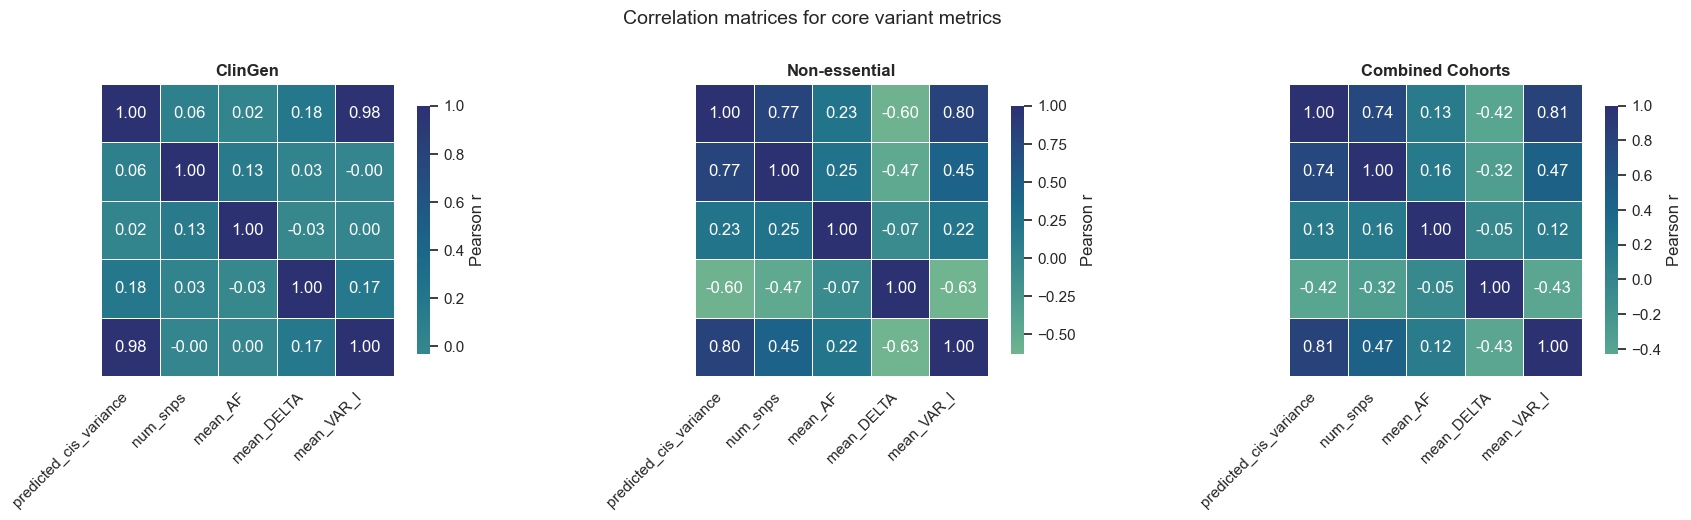

In [52]:
sns.set_theme(style="white")

core_cols = [
    "predicted_cis_variance",
    "num_snps",
    "mean_AF",
    "mean_DELTA",
    "mean_VAR_I"
]

def corr_heatmap(df: pd.DataFrame, title: str, ax=None):
    """
    Compute Pearson correlation matrix for *core_cols* in *df*
    and draw a seaborn heat-map on *ax* (or a new one if None).
    Returns the correlation DataFrame.
    """
    corr = df[core_cols].corr(method="pearson")
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        corr, annot=True, fmt=".2f", cmap="crest", center=0,
        linewidths=0.5, square=True, cbar_kws={"shrink": 0.85, "label": "Pearson r"},
        ax=ax
    )
    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    return corr

# ──-─  Build the three matrices in one figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

corr_clingen      = corr_heatmap(var_df_clingen,      "ClinGen",            ax=axes[0])
corr_nonessential = corr_heatmap(var_df_nonessential, "Non-essential",      ax=axes[1])
corr_combined     = corr_heatmap(var_df_all,          "Combined Cohorts",   ax=axes[2])

fig.suptitle("Correlation matrices for core variant metrics", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

# Keep the results handy if needed later
corr_matrices = {
    "ClinGen": corr_clingen,
    "Non-essential": corr_nonessential,
    "Combined": corr_combined
}

- Variant count drives variance only in non-essential genes; ClinGen genes stay flat.
- In both sets the total variance is basically the per-SNP VAR_I multiplied up.
- Allele-frequency adds a small boost, noticeable only when constraint is weak.
- ClinGen: larger Δ raises variance.Non-essential: genes with strongly negative mean Δ (net down-regulation) show higher variance.
- For non-essential genes, loci with more SNPs also carry bigger per-SNP effects – amplifying the total variance.


1. Dosage-sensitive genes uncouple from SNP burden
In ClinGen HI genes, the sheer number of common variants barely affects predicted variance (r ≈ 0). Their spread is almost entirely set by the typical per-variant contribution (mean VAR_I).
2. Non-essential genes accumulate “quantity and punch”
They not only harbour many more SNPs (and variance scales with count, r ≈ 0.8) but those SNPs also tend to have larger effect sizes (mean VAR_I ↑ when num_snps ↑). Constraint is weak, so both axes inflate variance.
3. Direction of effect matters only when selection is weak
Mean Δ is mildly positive in ClinGen, so larger |Δ| increases variance (positive r). In Non-essential genes mean Δ skews negative; the more down-regulating the average SNP, the bigger the summed variance (strong negative r).
4. Allele frequency is a secondary, permissive factor
Commoner alleles (higher mean AF) nudge variance upward, but the effect is modest compared to Δ or SNP count and is negligible under strong constraint.
5. Combined matrix mirrors the Non-essential pattern
Because those outlier non-essential genes dominate the high end, the pan-genome correlations largely reflect their behaviour; always inspect cohorts separately.

### 4.2 Partial correlation Analysis

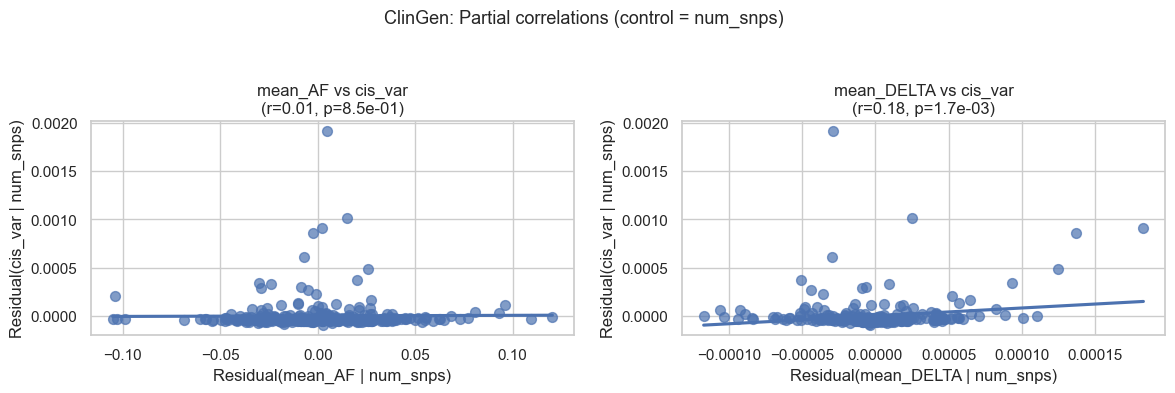

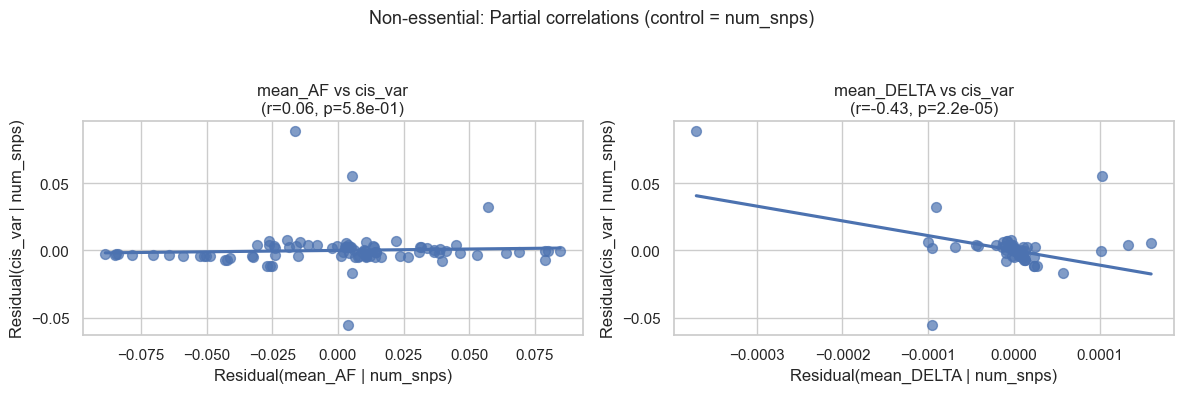

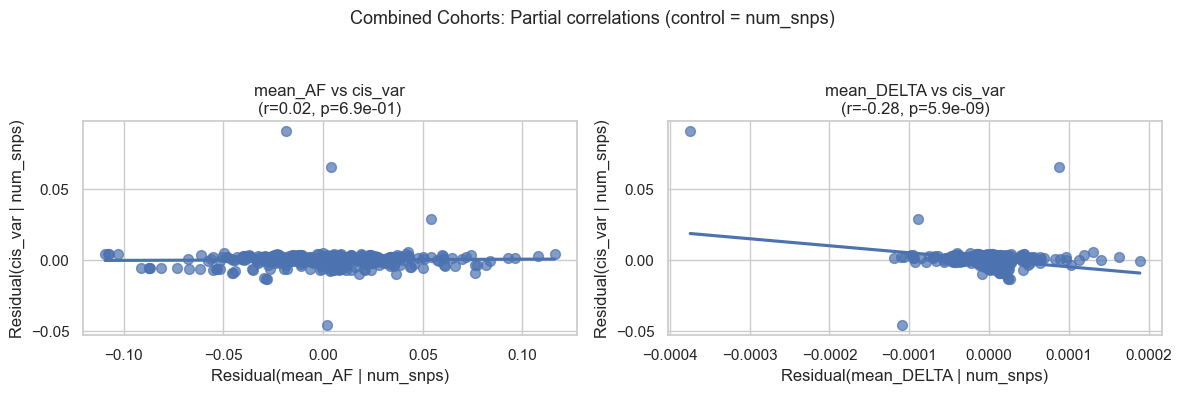


Partial correlation summary across cohorts:

             Cohort           X        Y   Control  Partial_Pearson_r  \
0           ClinGen     mean_AF  cis_var  num_snps              0.011   
1           ClinGen  mean_DELTA  cis_var  num_snps              0.176   
2     Non-essential     mean_AF  cis_var  num_snps              0.058   
3     Non-essential  mean_DELTA  cis_var  num_snps             -0.427   
4  Combined Cohorts     mean_AF  cis_var  num_snps              0.020   
5  Combined Cohorts  mean_DELTA  cis_var  num_snps             -0.284   

   Partial_Pearson_p  
0              0.847  
1              0.002  
2              0.582  
3              0.000  
4              0.691  
5              0.000  


In [25]:
sns.set_theme(style="whitegrid")

for _df in (var_df_clingen, var_df_nonessential, var_df_all):
    _df["cis_var"] = _df["predicted_cis_variance"]

def partial_corr(x, y, control, method="pearson"):
    """
    Returns r, p, residuals(x|control), residuals(y|control)
    """
    X = sm.add_constant(control)
    resid_x = sm.OLS(x, X).fit().resid
    resid_y = sm.OLS(y, X).fit().resid
    if method == "pearson":
        r, p = pearsonr(resid_x, resid_y)
    elif method == "spearman":
        r, p = spearmanr(resid_x, resid_y)
    else:
        raise ValueError("method must be 'pearson' or 'spearman'")
    return r, p, resid_x, resid_y


def partial_corr_overview(df, cohort_name,
                          features=("mean_AF", "mean_DELTA"),
                          control_col="num_snps"):
    """
    Draws residual-vs-residual plots and returns a summary DF of r & p.
    """
    results = []
    fig, axes = plt.subplots(1, len(features),
                             figsize=(6 * len(features), 4),
                             sharex=False, sharey=False)

    if len(features) == 1:
        axes = [axes]

    for i, feat in enumerate(features):
        r, p, res_x, res_y = partial_corr(df["cis_var"],
                                          df[feat],
                                          df[control_col])
        # store stats
        results.append(dict(
            Cohort=cohort_name,
            X=feat,
            Y="cis_var",
            Control=control_col,
            Partial_Pearson_r=r,
            Partial_Pearson_p=p
        ))

        sns.regplot(x=res_y, y=res_x, ci=None,
                    scatter_kws={"s": 50, "alpha": 0.7},
                    ax=axes[i])
        axes[i].set_xlabel(f"Residual({feat} | {control_col})")
        axes[i].set_ylabel("Residual(cis_var | num_snps)")
        axes[i].set_title(f"{feat} vs cis_var\n(r={r:.2f}, p={p:.1e})")

    fig.suptitle(f"{cohort_name}: Partial correlations (control = {control_col})",
                 fontsize=13)
    fig.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    return pd.DataFrame(results)


partial_results = {}
for _df, _name in [
    (var_df_clingen,      "ClinGen"),
    (var_df_nonessential, "Non-essential"),
    (var_df_all,          "Combined Cohorts")
]:
    partial_results[_name] = partial_corr_overview(_df, _name)

partial_summary = pd.concat(partial_results.values(), ignore_index=True)
print("\nPartial correlation summary across cohorts:\n")
print(partial_summary.round(3))

1.	SNP burden was the big confounder for AF. Once we strip it out, allele frequency no longer carries explanatory power in any cohort.
Effect-size distribution remains key but behaves oppositely
- ClinGen: bigger |Δ| ⇒ more variance (positive partial r).
- Non-essential: the farther mean Δ drifts negative, the larger the variance (negative partial r). → Under weak constraint, variant effects skew towards down-regulation and variance climbs; in HI genes, both up- and down-regulating variants are rare, so variance rises only with absolute magnitude.

2. clinGen keeps variance low mainly by limiting effect sizes, not by limiting SNP counts or favouring low-frequency alleles.
- Non-essential genes accumulate many SNPs; after counting them out, the deciding factor is whether their average push is down-regulatory.

- Any genome-wide predictor of expression variability should include both the number of variants and the signed mean Δ, but the slope for mean Δ needs to be gene-set specific (positive for essential, negative for non-essential).

multiple regression with interaction:

In [53]:
cln = var_df_clingen.copy()
nes = var_df_nonessential.copy()

cln["cohort"] = "ClinGen"
nes["cohort"] = "Non-essential"

df = pd.concat([cln, nes], ignore_index=True)

# Keep only rows with non-zero variance / SNPs
df = df[(df["predicted_cis_variance"] > 0) & (df["num_snps"] > 0)].copy()

# Add log-transformed predictors / outcome
df["log10_var"]       = np.log10(df["predicted_cis_variance"])
df["log10_num_snps"]  = np.log10(df["num_snps"])

# --------------------------------------------------------------------
# 2.  Fit OLS with interaction terms
# --------------------------------------------------------------------
formula = ("log10_var ~ C(cohort) * mean_DELTA "
           "+ C(cohort) * mean_VAR_I "
           "+ log10_num_snps")

model = smf.ols(formula, data=df).fit()

print(model.summary())

# --------------------------------------------------------------------
# 3.  Small, readable coefficient table
# --------------------------------------------------------------------
coef_tbl = (model.params
            .to_frame("coef")
            .join(model.bse.rename("se"))
            .join(model.pvalues.rename("pval"))
            .assign(t=lambda x: x["coef"]/x["se"])
            .round(4))

display(coef_tbl)

                            OLS Regression Results                            
Dep. Variable:              log10_var   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     40.26
Date:                Tue, 01 Jul 2025   Prob (F-statistic):           2.81e-38
Time:                        00:58:22   Log-Likelihood:                -580.11
No. Observations:                 406   AIC:                             1174.
Df Residuals:                     399   BIC:                             1202.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

,coef,se,pval,t
Intercept,-9.226200e+00,1.2664,0.0000,-7.2855
C(cohort)[T.Non-essential],-1.301900e+00,0.1531,0.0000,-8.5060
mean_DELTA,-5.893104e+02,1672.3427,0.7247,-0.3524
C(cohort)[T.Non-essential]:mean_DELTA,5.822366e+02,2864.4715,0.8390,0.2033
mean_VAR_I,6.769151e+06,857219.4605,0.0000,7.8966
C(cohort)[T.Non-essential]:mean_VAR_I,-6.101386e+06,861956.8769,0.0000,-7.0785
log10_num_snps,1.183900e+00,0.3772,0.0018,3.1390


ClinGen genes keep their expression variance in check primarily by suppressing the per-variant impact (mean VAR_I). Non-essential genes carry many more variants, but each has on average a much smaller effect, so the same rise in mean VAR_I inflates variance about ten times less steeply. Once we account for these two levers—variant count and per-variant punch—the signed direction of effects (mean Δ) adds nothing.

## VGH gene metrics

GTEx metric: Variance explained by fenetic factors in humans. the fraction of expression variance for a gene that is attributable to common cis variants across tissues.

Higher VGH means that gene is tolerant to regulatory perturbation. We are using it in to see if genes that tolerate dosage swings also show higher predicted variance.

Loaded VGH: (26760, 17)

ClinGen:  merged N = 313
  Pearson  r = -0.002  p = 9.78e-01
  Spearman r = 0.023  p = 6.87e-01

Non-essential:  merged N = 53
  Pearson  r = 0.309  p = 2.41e-02
  Spearman r = -0.005  p = 9.70e-01

Combined:  merged N = 366
  Pearson  r = 0.398  p = 2.31e-15
  Spearman r = -0.016  p = 7.55e-01


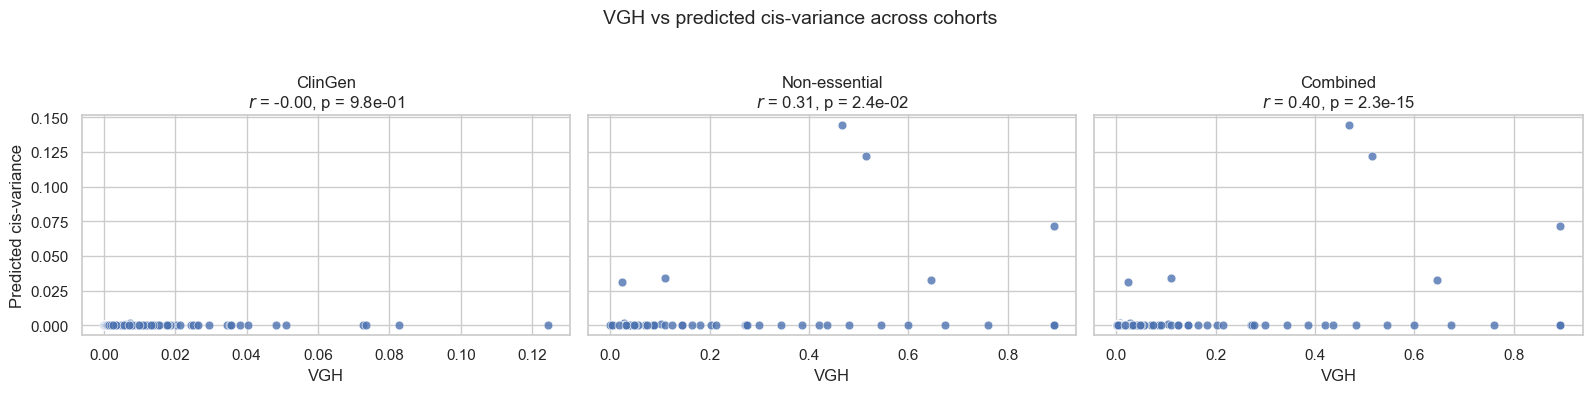

In [26]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

vgh = (pd.read_csv(gene_metrics_vgh, sep="\t", index_col=0)
         .reset_index()
         .rename(columns={"index": "gene_id"}))

vgh["gene_base"] = vgh["gene_id"].str.replace(r"\.\d+$", "", regex=True)
print("Loaded VGH:", vgh.shape)

# sanity
required_cols = {"gene_base", "vgh"}
assert required_cols.issubset(vgh.columns), \
    f"VGH file missing {required_cols - set(vgh.columns)}"

def merge_and_stats(var_df, cohort_label):
    if "gene_base" not in var_df.columns:
        var_df = var_df.assign(
            gene_base=var_df["gene_id"].str.replace(r"\.\d+$", "", regex=True)
        )
    df = (pd.merge(var_df, vgh, on="gene_base", how="inner")
            .dropna(subset=["vgh", "predicted_cis_variance"]))

    prs, p_p = pearsonr(df["vgh"], df["predicted_cis_variance"])
    spr, p_s = spearmanr(df["vgh"], df["predicted_cis_variance"])

    print(f"\n{cohort_label}:  merged N = {len(df)}")
    print(f"  Pearson  r = {prs:.3f}  p = {p_p:.2e}")
    print(f"  Spearman r = {spr:.3f}  p = {p_s:.2e}")
    return df, prs, p_p

cohort_dfs = {}
for lbl, df in [("ClinGen", var_df_clingen),
                ("Non-essential", var_df_nonessential),
                ("Combined", var_df_all)]:
    cohort_dfs[lbl] = merge_and_stats(df, lbl)[0]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
for ax, (lbl, mdf) in zip(axes, cohort_dfs.items()):
    sns.scatterplot(data=mdf, x="vgh", y="predicted_cis_variance",
                    s=40, alpha=0.8, ax=ax)
    r, p = pearsonr(mdf["vgh"], mdf["predicted_cis_variance"])
    ax.set_title(f"{lbl}\n$r$ = {r:.2f}, p = {p:.1e}")
    ax.set_xlabel("VGH")
    ax.set_ylabel("Predicted cis-variance" if ax is axes[0] else "")

fig.suptitle("VGH vs predicted cis-variance across cohorts", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

1. Dosage-sensitive genes (ClinGen) stay flat.
Even when GTEx data say a gene’s expression varies easily in the population (high VGH), our sequence-based predictor still assigns them low cis-variance. This is consistent with purifying selection: prediction model sees few high-impact variants, so variance stays small.
2. Non-essential genes show a hint of alignment—but only via outliers.
Pearson r ≈ 0.31 suggests “more tolerant → higher predicted variance,” but Spearman ≈ 0 and the plot shows a vertical stack of near-zero points plus a handful of extreme VGH & variance genes. Remove those and the trend vanishes.
3. Combined cohort correlation is an artefact.
When ClinGen (all near the origin) is merged with a few non-essential outliers, Pearson inflates to 0.40. Rank-based ρ stays null, confirming the relationship is not genome-wide.

### Summary

Recap

1.	Variant scoring – Borzoi furnishes a signed effect (Δ) for every common SNV (AF ≥ 1 %) in ±262 kb promoter windows.
2.	Per-variant variance term – For additive, independent variants we set
${VAR\_I}=2p(1-p)\,\Delta^{2}$
then sum within each gene ⇒ predicted cis-variance.
3.	Gene-level tables – metrics per gene: number of SNPs, mean AF, mean Δ, mean VAR_I, summed variance.
4.	Cohorts – 314 ClinGen haplo-insufficient (HI) genes vs 92 “non-essential” genes; plus a combined background of ~400 loci.

- Can deep learning predict how common variants influence expression variability?
Yes, partly. Borzoi-based variance scores separate dosage-constrained from tolerant genes and explain ~38 % of gene-to-gene σ² spread with only three predictors (mean VAR_I, SNP count, cohort)
---------

Main observations

- ClinGen haplo-insufficient (HI) genes show much lower σ² and a tighter spread than “non-essential” genes.
- In HI genes, σ² is driven almost entirely by the average impact of each variant (mean VAR_I); the raw number of SNPs hardly matters.
- In non-essential genes the opposite holds: many SNPs (plus a few extreme ones) blow up σ².
- Direction of effect (mean Δ) behaves differently: positive relation in HI genes, negative in non-essentials.
- A simple interaction model (log10 σ² ~ cohort * mean_VAR_I + log10 SNPs) explains ~40 % of the gene-to-gene spread.
--------
- The sequence-derived σ² neatly tracks evolutionary dosage constraint: genes under strong purifying selection have little “wiggle room.”
- That makes σ² a useful prior for downstream analyses—e.g. stricter DE thresholds for low-σ² genes, relaxed ones for high-σ² genes; or ranking variants by Δ / σ_g.
------
- GTEx VGH (how much real-life expression variance comes from genetics) correlates with our σ² only through a handful of outlier genes; inside HI genes there’s essentially no match.